### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


#Supress Sklearn Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Importing our functions

In [2]:
from functions import (compute_metrics,trivial,nearest_means,PCA_analysis,
                       PCA_func,seq_feat_selector,k_fold,cross_val)

### Importing the Datasets

In [3]:
train = pd.read_csv('algerian_fires_train.csv')
test = pd.read_csv('algerian_fires_test.csv')

### Feature Engineering

#### Creating Additional Features from Existing Features

In [4]:
frames = [train,test] #Combining train and test datasets 
data = pd.concat(frames)      

#### 1. Creating Avgerage,Min,Max features for Temp, RH, Ws, Rain based on recordings for the past 7 days

In [5]:
data = data.assign(Avg_Temp = data.rolling(6,min_periods=1,closed='left').Temperature.mean()) 
data['Avg_Temp'][1::2]=data.rolling(7,min_periods=1,closed='left').Temperature.mean()[1::2]  
data = data.assign(Min_Temp = data.rolling(6,min_periods=1,closed='left').Temperature.min())
data['Min_Temp'][1::2]=data.rolling(7,min_periods=1,closed='left').Temperature.min()[1::2]
data = data.assign(Max_Temp = data.rolling(6,min_periods=1,closed='left').Temperature.max())
data['Max_Temp'][1::2]=data.rolling(7,min_periods=1,closed='left').Temperature.max()[1::2]

data = data.assign(Avg_RH = data.rolling(6,min_periods=1,closed='left').RH.mean())
data['Avg_RH'][1::2]=data.rolling(7,min_periods=1,closed='left').RH.mean()[1::2]
data = data.assign(Min_RH = data.rolling(6,min_periods=1,closed='left').RH.min())
data['Min_RH'][1::2]=data.rolling(7,min_periods=1,closed='left').RH.min()[1::2]
data = data.assign(Max_RH = data.rolling(6,min_periods=1,closed='left').RH.max())
data['Max_RH'][1::2]=data.rolling(7,min_periods=1,closed='left').RH.max()[1::2]

data = data.assign(Avg_Ws = data.rolling(6,min_periods=1,closed='left').Ws.mean())
data['Avg_Ws'][1::2]=data.rolling(7,min_periods=1,closed='left').Ws.mean()[1::2]
data = data.assign(Min_Ws = data.rolling(6,min_periods=1,closed='left').Ws.min())
data['Min_Ws'][1::2]=data.rolling(7,min_periods=1,closed='left').Ws.min()[1::2]
data = data.assign(Max_Ws = data.rolling(6,min_periods=1,closed='left').Ws.max())
data['Max_Ws'][1::2]=data.rolling(7,min_periods=1,closed='left').Ws.max()[1::2]

data = data.assign(Avg_Rain = data.rolling(6,min_periods=1,closed='left').Rain.mean())
data['Avg_Rain'][1::2]=data.rolling(7,min_periods=1,closed='left').Rain.mean()[1::2]
data = data.assign(Min_Rain = data.rolling(6,min_periods=1,closed='left').Rain.min())
data['Min_Rain'][1::2]=data.rolling(7,min_periods=1,closed='left').Rain.min()[1::2]
data = data.assign(Max_Rain = data.rolling(6,min_periods=1,closed='left').Rain.max())
data['Max_Rain'][1::2]=data.rolling(7,min_periods=1,closed='left').Rain.max()[1::2]

In [6]:
#Filling the NaN values of first data point with same dates values
data.iloc[0,11] = data.iloc[0,1]
data.iloc[0,12] = data.iloc[0,1]
data.iloc[0,13] = data.iloc[0,1]
data.iloc[0,14] = data.iloc[0,2]
data.iloc[0,15] = data.iloc[0,2]
data.iloc[0,16] = data.iloc[0,2]
data.iloc[0,17] = data.iloc[0,3]
data.iloc[0,18] = data.iloc[0,3]
data.iloc[0,19] = data.iloc[0,3]
data.iloc[0,20] = data.iloc[0,4]
data.iloc[0,21] = data.iloc[0,4]
data.iloc[0,22] = data.iloc[0,4]

#### 2. Adding a New Feature of Weekday/Weekend to see if Fires are more common during Weekdays/Weekends

In [7]:
data['Date'] = pd.to_datetime(data.Date, dayfirst=True)
data['Day of Week'] = data['Date'].dt.dayofweek
data['Weekday/Weekend'] = np.where(data['Day of Week'] < 5, 1, 0)

#### 3. Creating Higher Dimensional Features using Sklearn Polynomial Features Function


In [8]:
columns = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']
poly = PolynomialFeatures(2)
expanded_data = poly.fit_transform(data[columns])
feature_names = poly.get_feature_names_out(input_features=None)

expanded_data = pd.DataFrame(expanded_data, columns=feature_names)
expanded_data = expanded_data.drop(columns=['1'])

#### Reordering Data Indices

In [10]:
data.reset_index(inplace=True)

expanded_data.insert(1, "Avg_Temp", data['Avg_Temp'])
expanded_data.insert(2, "Min_Temp", data['Min_Temp'])
expanded_data.insert(3, "Max_Temp", data['Max_Temp'])

expanded_data.insert(5, "Avg_RH", data['Avg_RH'])
expanded_data.insert(6, "Min_RH", data['Min_RH'])
expanded_data.insert(7, "Max_RH", data['Max_RH'])

expanded_data.insert(9, "Avg_Ws", data['Avg_Ws'])
expanded_data.insert(10, "Min_Ws", data['Min_Ws'])
expanded_data.insert(11, "Max_Ws", data['Max_Ws'])

expanded_data.insert(12, "Avg_Rain", data['Avg_Rain'])
expanded_data.insert(13, "Min_Rain", data['Min_Rain'])
expanded_data.insert(14, "Max_Rain", data['Max_Rain'])
expanded_data.insert(0, "Weekday/Weekend", data['Weekday/Weekend'])
expanded_data.insert(1, "Classes", data['Classes'])

expanded_data.insert(len(expanded_data.columns)-1, 'Classes', expanded_data.pop('Classes'))

### Train-Test Split

In [11]:
columns = []
for column in expanded_data.columns:
    columns.append(column)

expanded_train = expanded_data[:184]
expanded_train = pd.DataFrame(expanded_train, columns=columns)
expanded_test = expanded_data[184:]
expanded_test = pd.DataFrame(expanded_test, columns=columns)

expanded_train.drop(expanded_train.tail(6).index,inplace=True)  #Dropping the last 3 dates before test data first date

### Standardization

In [12]:
scaler = StandardScaler()
scaler.fit(expanded_train.loc[:, expanded_train.columns != 'Classes'])

expanded_train.loc[:, expanded_train.columns != 'Classes'] = scaler.transform(expanded_train.loc[:, expanded_train.columns != 'Classes'])
expanded_train = pd.DataFrame(expanded_train, columns=columns)
expanded_test.loc[:, expanded_test.columns != 'Classes'] = scaler.transform(expanded_test.loc[:, expanded_test.columns != 'Classes'])
expanded_test = pd.DataFrame(expanded_test, columns=columns)

#### Appending Class Labels to the End

In [13]:
expanded_train.insert(len(expanded_train.columns)-1, 'Classes', expanded_train.pop('Classes'))
expanded_test.insert(len(expanded_test.columns)-1, 'Classes', expanded_test.pop('Classes'))

#### Seperating the Features and the Class Labels

In [14]:
expanded_train_features = expanded_train.drop(columns=['Classes'])
expanded_train_classes = expanded_train['Classes']

expanded_test_features = expanded_test.drop(columns=['Classes'])
expanded_test_classes = expanded_test['Classes']

### PCA Analysis

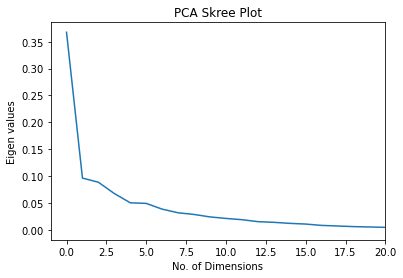

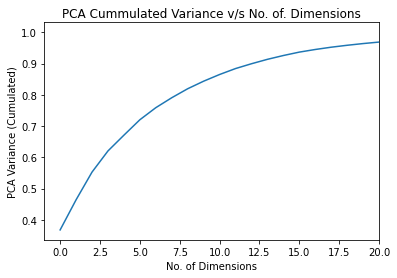

In [15]:
PCA_analysis(expanded_train_features)

## Models

### 1. Support Vector Machines (SVM)

In [16]:
def SVM_func(folds,folds_classes):
    max_accuracy = 0
    max_f1_score = 0
    best_C = 0
    best_gamma = 0
    best_kernel = 'None'
    C_list = [0.1,1,10,100,1000]
    gamma_list = [1,0.1,0.01,0.001,0.0001]
    kernel_list = ['rbf','linear','poly']
    for i in range(len(C_list)):
        for j in range(len(gamma_list)):
            for k in range(len(kernel_list)):
                accuracy = []
                scores_list=[]
                train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
                for l in range(len(train_classes_folds)):
                    sv = SVC(C=C_list[i],gamma=gamma_list[j],kernel=kernel_list[k])
                    sv.fit(train_features_folds[l],train_classes_folds[l])
                    Y_pred_svm = sv.predict(val_features_folds[l].values)
                    svm_score=accuracy_score(val_classes_folds[l],Y_pred_svm)*100
                    svm_f1_score = f1_score(val_classes_folds[l],Y_pred_svm)
                    scores_list.append(svm_f1_score)
                    accuracy.append(svm_score)
                
                if np.mean(scores_list) > max_f1_score:
                    max_f1_score = np.mean(scores_list)
                    best_C = C_list[i]
                    best_gamma = gamma_list[j]
                    best_kernel = kernel_list[k]
                
    
    print('SVM has the best f1_score of ', max_f1_score, ' for: C = ', best_C, ' , gamma = ', best_gamma, ' , kernel = ', best_kernel)    

### 2. Sklearn Neural Network

In [17]:
def NN(folds,folds_classes):
    accuracy = []
    scores_list = []
    train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
    classifier = MLPClassifier(hidden_layer_sizes=(200,200,200,200),max_iter=300,shuffle=False,random_state=3)
    for i in range(len(train_classes_folds)):
        classifier.fit(train_features_folds[i],train_classes_folds[i])
        acc = classifier.score(val_features_folds[i],val_classes_folds[i])
        y_pred = classifier.predict(val_features_folds[i])
        f1score = f1_score(val_classes_folds[i],y_pred)
        accuracy.append(acc) 
        scores_list.append(f1score)
    print (f'Accuracy: NN is {np.mean(accuracy)*100}%')
    print(f'F1 Score: NN {np.mean(scores_list)}') 

### 3. Keras ANN

In [18]:
def ANN_keras(folds,folds_classes):
    accuracy = []
    scores_list = []
    train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
    for i in range(len(train_classes_folds)):
        classifier = Sequential()
        classifier.add(Dense(units=10,kernel_initializer='he_normal',activation='relu'))
        classifier.add(Dense(units=7,kernel_initializer='he_normal',activation='relu'))
        classifier.add(Dense(units=1,kernel_initializer='he_normal',activation='sigmoid'))
        classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
        classifier.fit(train_features_folds[i],train_classes_folds[i],epochs=100,verbose=0)
        y_pred_nn = (classifier.predict(val_features_folds[i])>0.5)
        accuracy.append(accuracy_score(y_pred_nn,val_classes_folds[i]))
        scores_list.append(f1_score(val_classes_folds[i],y_pred_nn)) 
    print (f'Acc: KerasNN is {np.mean(accuracy)*100}%')
    print (f'f1score: KerasNN is {np.mean(scores_list)}')  

### 4. K Nearest Neighbors (KNN)

In [19]:
def KNN(folds,folds_classes):
    max_accuracy = 0
    max_f1_score = 0
    best_n = 0
    best_weight = 'None'
    best_metric = 'None'
    neighbors_list = [1,2,3,4,5,6,7,8,9,10]
    weight_list = ['uniform','distance']
    metric_list = ['minkowski','chebyshev','euclidean']
    for i in range(len(neighbors_list)):
        for j in range(len(weight_list)):
            for k in range(len(metric_list)):
                accuracy = []
                scores_list =[]
                train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
                for l in range(len(train_classes_folds)):
                    knn = KNeighborsClassifier(n_neighbors=neighbors_list[i],weights=weight_list[j],metric=metric_list[k])
                    knn.fit(train_features_folds[l],train_classes_folds[l])
                    Y_pred_knn = knn.predict(val_features_folds[l])
                    knn_score=accuracy_score(val_classes_folds[l],Y_pred_knn)*100
                    knn_f1score = f1_score(val_classes_folds[l],Y_pred_knn)
                    accuracy.append(knn_score)
                    scores_list.append(knn_f1score)


                
                if np.mean(scores_list) > max_f1_score:
                    max_f1_score = np.mean(scores_list)
                    best_n = neighbors_list[i]
                    best_weight = weight_list[j]
                    best_metric = metric_list[k]
                    
    print('KNN has the best f1_score of ', max_f1_score, ' for: number of neighbors = ', best_n, ' , weight = ', best_weight
    , ',metric = ', best_metric)

### 5. Ridge Classifier

In [20]:
def ridge_class(folds,folds_classes):
    max_f1_score = 0
    max_accuracy = 0
    best_alpha = 0
    best_solver = 'None'
    best_intercept = 'None'
    alpha_list = [0.1,1,10]
    solver_list = ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']
    intercept_list = ['minkowski','chebyshev','euclidean']
    for i in range(len(alpha_list)):
        for j in range(len(solver_list)):
            for k in range(len(intercept_list)):
                accuracy = []
                scores_list=[]
                train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
                for l in range(len(train_classes_folds)):
                    classifier = RidgeClassifier(alpha=alpha_list[i],solver=solver_list[j],class_weight='balanced',
                                                fit_intercept=intercept_list[k])
                    classifier.fit(train_features_folds[l],train_classes_folds[l])
                    Y_pred_ridge = classifier.predict(val_features_folds[l])
                    ridge_score=accuracy_score(val_classes_folds[l],Y_pred_ridge)*100
                    ridge_f1_score = f1_score(val_classes_folds[l],Y_pred_ridge)
                    accuracy.append(ridge_score)
                    scores_list.append(ridge_f1_score)
                
                if np.mean(scores_list) > max_f1_score:
                    max_f1_score = np.mean(scores_list)
                    best_alpha = alpha_list[i]
                    best_solver = solver_list[j]
                    best_intercept = intercept_list[k]
                    
    print('Ridge Classifier has the best f1_score of ', max_f1_score, ' for: alpha = ', best_alpha, ' , solver = ', best_solver,
         ' , intercept = ', best_intercept)


### 6. Logistic Regression Classifier

In [21]:
def log_reg(folds,folds_classes):
    max_accuracy = 0
    max_f1_score=0
    best_solver = 'None'
    solver_list = ['newton-cg','liblinear','lbfgs']
    for i in range(len(solver_list)):
        accuracy = []
        scores_list=[]
        train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
        for l in range(len(train_classes_folds)):
            classifier = LogisticRegression(solver=solver_list[i],penalty='l2')
            classifier.fit(train_features_folds[l],train_classes_folds[l])
            Y_pred_logreg = classifier.predict(val_features_folds[l])
            logreg_score=accuracy_score(val_classes_folds[l],Y_pred_logreg)*100
            accuracy.append(logreg_score)
            logreg_f1score = f1_score(val_classes_folds[l],Y_pred_logreg)
            scores_list.append(logreg_f1score)

        if np.mean(scores_list) > max_f1_score:
            max_f1_score = np.mean(scores_list)
            best_solver = solver_list[i]
            
    print('Logistic Regression Classifier has the best f1_score of ', max_f1_score, ' for: solver = ', best_solver)

### 7. Random Forest Classifier

In [22]:
def rand_forest(folds,folds_classes):
    max_accuracy = 0
    max_f1_score=0
    best_features = 'none'
    best_criterion = 'none'
    best_n_est = 0
    
    features_list = ['auto','sqrt','log2']
    criterion_list = ['gini','entropy']
    n_est_list = [100,200,300,350]
    
    for i in range(len(features_list)):
        for j in range(len(criterion_list)):
            for k in range(len(n_est_list)):
                accuracy = []
                scores_list=[]
                train_features_folds,train_classes_folds,val_features_folds,val_classes_folds = cross_val(folds,folds_classes)
                for l in range(len(train_classes_folds)):
                    rf = RandomForestClassifier(max_features=features_list[i],criterion=criterion_list[j],n_estimators=n_est_list[k])
                    rf.fit(train_features_folds[l],train_classes_folds[l])
                    Y_pred_rf = rf.predict(val_features_folds[l])
                    rf_score=accuracy_score(val_classes_folds[l],Y_pred_rf)*100
                    rf_f1score = f1_score(val_classes_folds[l],Y_pred_rf)
                    scores_list.append(rf_f1score)
                    accuracy.append(rf_score)
                
                if np.mean(scores_list) > max_f1_score:
                    max_f1_score = np.mean(scores_list)
                    best_features = features_list[i]
                    best_criterion = criterion_list[j]
                    best_n_est = n_est_list[k]
    
    print('Random Forest has the best f1_score of ', max_f1_score, ' for: max_features = ', best_features, ' , criterion = ',
     best_criterion, ' , n_estimators = ', best_n_est)

## Model Selection using PCA

In [25]:
def model_selection_PCA(min_dim,max_dim):
    for i in range(min_dim,max_dim):
        PCA_train,PCA_test = PCA_func(expanded_train_features,expanded_test_features,i)
        folds, folds_classes = k_fold(PCA_train,expanded_train_classes)

        print('SVM:')
        SVM_func(folds,folds_classes)
        print()

        print('Sklearn Neural Networks:')
        NN(folds,folds_classes)
        print()

        print('Keras ANN:')
        ANN_keras(folds,folds_classes)
        print()

        print('KNN:')
        KNN(folds,folds_classes)
        print()

        print('Ridge Classifier:')
        ridge_class(folds,folds_classes)
        print()

        print('Logistic Regression:')
        log_reg(folds,folds_classes)
        print()

        print('Random Forest:')
        rand_forest(folds,folds_classes)
        print("--------------------------------------------------------------------------------------------")

In [26]:
model_selection_PCA(9,10)

SVM:
SVM has the best f1_score of  0.922184747360063  for: C =  0.1  , gamma =  1  , kernel =  linear

Sklearn Neural Networks:
Accuracy: NN is 84.5959595959596%
F1 Score: NN 0.8548124927435272

Keras ANN:
1/1 [==============================] - 0s 58ms/step
Acc: KerasNN is 81.88131313131312%
f1score: KerasNN is 0.8475525009464518

KNN:
KNN has the best f1_score of  0.9025528085630388  for: number of neighbors =  10  , weight =  uniform ,metric =  minkowski

Ridge Classifier:
Ridge Classifier has the best f1_score of  0.843342731829574  for: alpha =  1  , solver =  saga  , intercept =  minkowski

Logistic Regression:
Logistic Regression Classifier has the best f1_score of  0.9287421864939027  for: solver =  newton-cg

Random Forest:
Random Forest has the best f1_score of  0.9017843930887409  for: max_features =  auto  , criterion =  gini  , n_estimators =  200
--------------------------------------------------------------------------------------------


## Model Selection using Sequential Feature Selection

In [28]:
def model_selection_sfs(train,labels,n_max):
    cols = seq_feat_selector(train,labels,n_max)
    train_sfs = train[cols]
    folds, folds_classes = k_fold(train_sfs,labels)

    print('SVM:')
    SVM_func(folds, folds_classes)
    print()

    print('Sklearn Neural Networks:')
    NN(folds, folds_classes)
    print()

    print('Keras ANN:')
    ANN_keras(folds, folds_classes)
    print()

    print('KNN:')
    KNN(folds,folds_classes)
    print()

    print('Ridge Classifier:')
    ridge_class(folds, folds_classes)
    print()

    print('Logistic Regression:')
    log_reg(folds, folds_classes)
    print()

    print('Random Forest:')
    rand_forest(folds, folds_classes)
    print("--------------------------------------------------------------------------------------------")


In [29]:
model_selection_sfs(expanded_train_features,expanded_train_classes,9)

SVM:
SVM has the best f1_score of  0.9411976911976913  for: C =  1  , gamma =  0.01  , kernel =  rbf

Sklearn Neural Networks:
Accuracy: NN is 89.58333333333334%
F1 Score: NN 0.8978490913273522

Keras ANN:
1/1 [==============================] - 0s 68ms/step
Acc: KerasNN is 90.84595959595958%
f1score: KerasNN is 0.9111583306091315

KNN:
KNN has the best f1_score of  0.9452582301419511  for: number of neighbors =  5  , weight =  uniform ,metric =  minkowski

Ridge Classifier:
Ridge Classifier has the best f1_score of  0.9425048127565291  for: alpha =  0.1  , solver =  auto  , intercept =  minkowski

Logistic Regression:
Logistic Regression Classifier has the best f1_score of  0.9346100759144238  for: solver =  liblinear

Random Forest:
Random Forest has the best f1_score of  0.9353315766359245  for: max_features =  auto  , criterion =  gini  , n_estimators =  100
--------------------------------------------------------------------------------------------


#### KNN using Sequential Feature Selection has the best performance with an F1 score of 0.945

## Pickling the Model File for Deployment

In [30]:
import pickle

In [31]:
cols = seq_feat_selector(expanded_train_features,expanded_train_classes,9)
train_sfs = expanded_train_features[cols]
test_sfs = expanded_test_features[cols]

In [42]:
knn = KNeighborsClassifier(n_neighbors=5,weights='uniform',metric='minkowski')
knn.fit(train_sfs,expanded_train_classes)
best_model_params = {}
best_model_params['columns'] = cols
best_model_params['model'] = knn
best_model_params['scaler'] = scaler
pickle.dump(best_model_params,open('./best_model.pkl','wb'))